# Getting stock data and installing necessary libraries

In [1]:
!pip install -q yfinance numpy pandas matplotlib tensorflow


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  4 of 4 completed


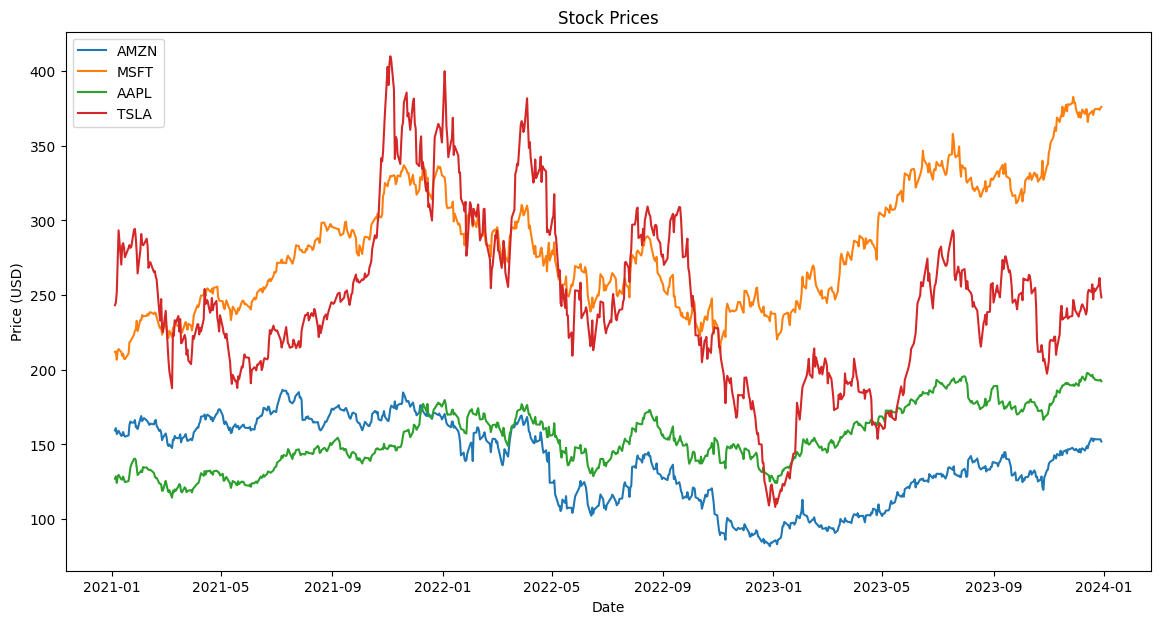

In [59]:

tickers = ["AMZN", "MSFT", "AAPL", "TSLA"]

stock_data = yf.download(tickers, start="2021-01-01", end="2024-01-01")['Adj Close']

plt.figure(figsize=(14, 7))

for ticker in tickers:
    plt.plot(stock_data[ticker], label=ticker)

plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


# Fetching data for APPLE (AAPL) stock

In [42]:
stock_symbol = 'AAPL'
start_date = '2021-01-01'
end_date = '2024-01-01'

data = yf.download(stock_symbol, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [43]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.002113,143301900
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.572342,97664900
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.244385,155088000
2021-01-07,128.360001,131.630005,127.860001,130.919998,128.484039,109578200
2021-01-08,132.429993,132.630005,130.229996,132.050003,129.592957,105158200


# VISUALIZATION


1.  **Line Plot** (to visualize the trend of the stock prices over time)
2.  **Histogram** (to visualize the distribution of stock prices)
3. **Moving Average** (to visualize the moving average of stock prices over a certain period)
4. **Box Plot** (to visualize the distribution of stock prices over different time periods, such as days of the week.)










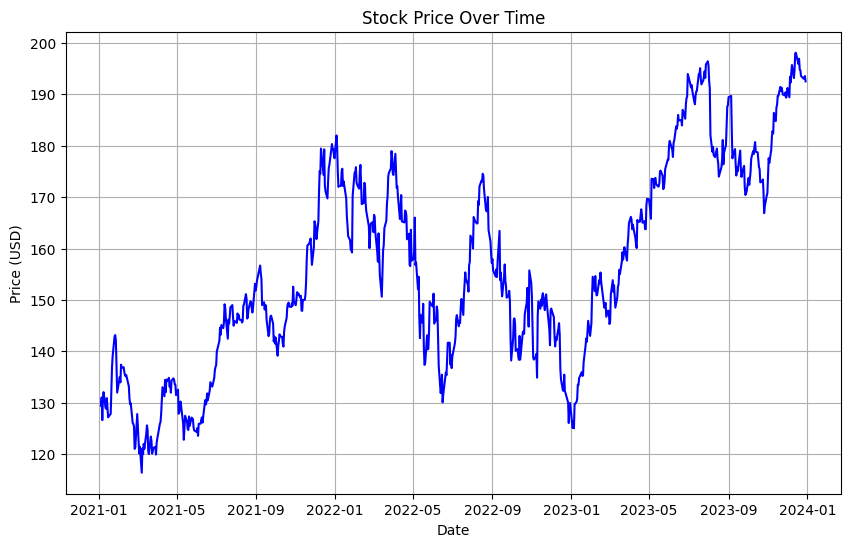

In [44]:
#linePlot
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], color='blue')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


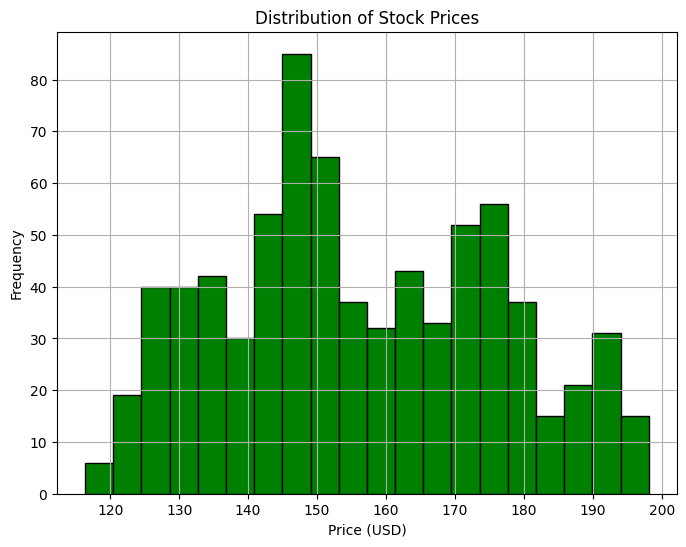

In [45]:
#histogram
#helps understand frequency of occurrence of different price ranges.
plt.figure(figsize=(8, 6))
plt.hist(data['Close'], bins=20, color='green', edgecolor='black')
plt.title('Distribution of Stock Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

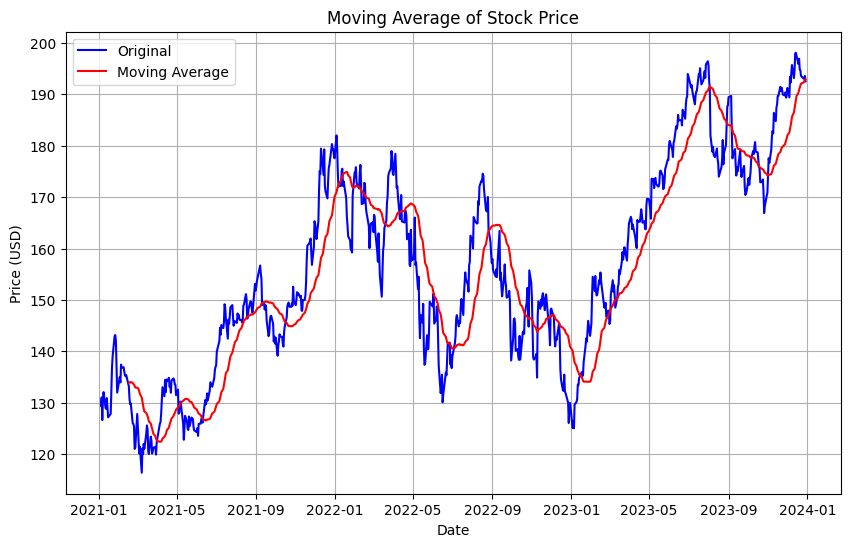

In [46]:
#Moving Average
# helps in smoothing out fluctuations and identifying trends more easily.
window_size = 30  # Choose a window size for moving average
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], color='blue', label='Original')
plt.plot(data['Close'].rolling(window=window_size).mean(), color='red', label='Moving Average')
plt.title('Moving Average of Stock Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

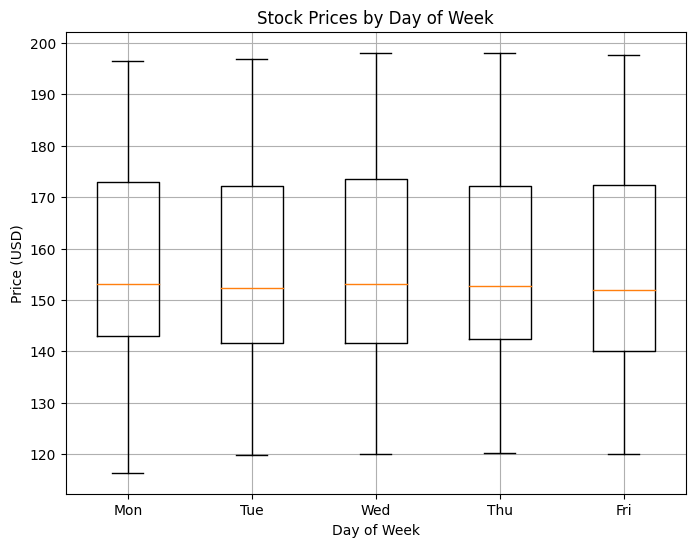

In [47]:
#BoxPlot
# helps in understanding if there are any outliers or if the distribution varies
# over different time periods.
data['Day_of_Week'] = data.index.dayofweek
plt.figure(figsize=(8, 6))
plt.boxplot([data[data['Day_of_Week'] == i]['Close'] for i in range(5)], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.title('Stock Prices by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

# Preprocessing the data


1.   Scaling the Data:
2.   Splitting the Data into Training (80%)and Testing Sets (20%):



In [48]:
# Convert the dataframe to a numpy array
dataset = data.values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split the data into training and testing sets60 is
# subtracted to include a window of data points for each prediction in the testing set.
# This ensures that the testing set has some overlap with the training set,
# which can help improve the model's performance.
training_data_len = int(np.ceil(0.8 * len(dataset)))
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 45:, :]


# Create Training Dataset


*   Create the dataset for training the LSTM model.




In [49]:
def create_dataset(data, time_step):
    x_data, y_data = [], []
    for i in range(len(data) - time_step - 1):
        x_data.append(data[i:(i + time_step), 0])
        y_data.append(data[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

time_step = 45
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape the data for LSTM input [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [50]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (557, 45, 1)
y_train shape: (557,)
x_test shape: (149, 45, 1)
y_test shape: (149,)


In [ ]:
print("x_train dataset:")
print(x_train)

print("\ny_train dataset:")
print(y_train)

print("\nx_test dataset:")
print(x_test)

print("\ny_test dataset:")
print(y_test)


# Create and compile the LSTM model.

In [52]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Adding dropout for regularization
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))  # Adding dropout for regularization
model.add(LSTM(units=100))
model.add(Dropout(0.2))  # Adding dropout for regularization
model.add(Dense(units=1))

# Adjust the learning rate and optimizer
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001)

model.compile(optimizer=adam, loss='mean_squared_error')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 45, 100)           40800     
                                                                 
 dropout_3 (Dropout)         (None, 45, 100)           0         
                                                                 
 lstm_8 (LSTM)               (None, 45, 100)           80400     
                                                                 
 dropout_4 (Dropout)         (None, 45, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

# Train the LSTM model using the training dataset.

In [ ]:
history = model.fit(x_train, y_train, batch_size=128, epochs=200, validation_data=(x_test, y_test), verbose=1)

In [55]:
# Evaluate the model on the test data
loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)


5/5 [==============================] - 0s 34ms/step - loss: 9.0135e-04
Test Loss: 0.0009013466187752783


In [56]:
# Make predictions on the test data
predictions = model.predict(x_test)

# Optionally, inverse transform predictions and actual values if you scaled them before
# predictions = scaler.inverse_transform(predictions)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate any additional evaluation metrics (e.g., Mean Absolute Error, R-squared)
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Absolute Error:", mae)
print("R-squared:", r2)


5/5 [==============================] - 1s 33ms/step
Mean Absolute Error: 0.02193139624713747
R-squared: 0.9147112995184631


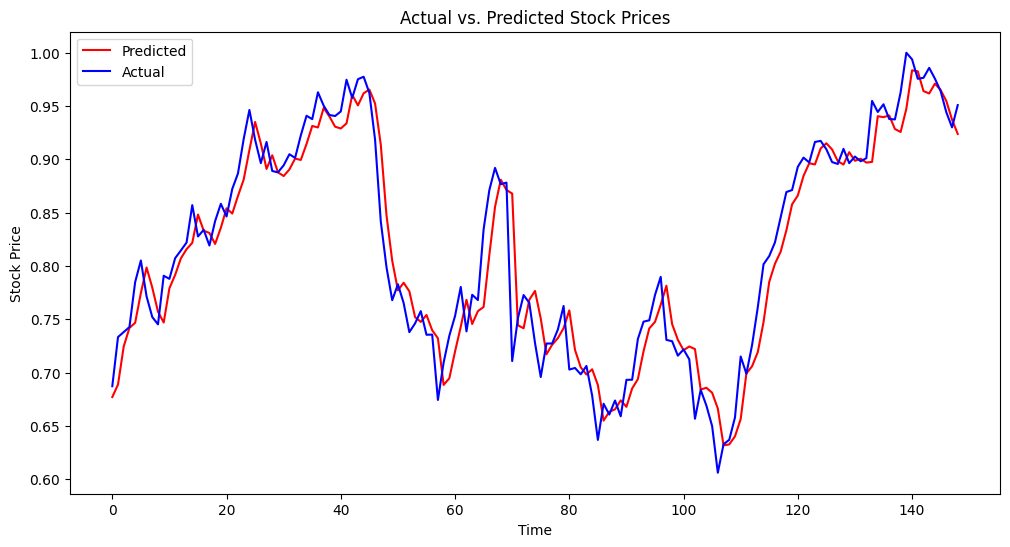

In [57]:
import matplotlib.pyplot as plt

# Inverse transform the scaled predictions and actual values if you scaled them before
# predictions = scaler.inverse_transform(predictions)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predicted', color='red')
plt.plot(y_test, label='Actual', color='blue')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [58]:
import pandas as pd

# Create a DataFrame for actual and predicted values
results_df = pd.DataFrame({'Actual': y_test.reshape(-1), 'Predicted': predictions.reshape(-1)})

# Display the DataFrame
print(results_df)


       Actual  Predicted
0    0.687302   0.677120
1    0.733384   0.688851
2    0.738068   0.724576
3    0.742752   0.741954
4    0.784909   0.746762
..        ...        ...
144  0.975693   0.971011
145  0.964046   0.965050
146  0.944170   0.954722
147  0.929991   0.937225
148  0.950880   0.923815

[149 rows x 2 columns]
